In [13]:
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

from nldg.new.archive.utils import (gen_data_v3,
                                    max_mse)
from nldg.new.archive.rf import RF4DG, MaggingRF, IsdRF, MaggingRF_PB

from scipy.optimize import minimize
from tqdm import tqdm

import matplotlib.pyplot as plt
import os
from nldg.utils.jbd import ajbd

In [2]:
dtr, dts = gen_data_v3(n_train=1000, n_test=500)
Xtr, Xts = np.array(dtr.drop(columns=['E', 'Y'])), np.array(dts.drop(columns=['E', 'Y']))
Ytr, Yts = np.array(dtr['Y']), np.array(dts['Y'])
Etr = np.array(dtr['E'])
min_samples_leaf = 10

In [4]:
def objective(w: np.ndarray, F: np.ndarray) -> float:
    return np.dot(w.T, np.dot(F.T, F).dot(w))

n_envs = len(np.unique(Etr))
winit = np.array([1 / n_envs] * n_envs)
constraints = {"type": "eq", "fun": lambda w: np.sum(w) - 1}
bounds = [[0, 1] for _ in range(n_envs)]

preds_envs = []
fitted_envs = []
for env in np.unique(Etr):
    Xtr_e = Xtr[Etr == env]
    Ytr_e = Ytr[Etr == env]
    Etr_e = Etr[Etr == env]
    rfm = RF4DG(criterion='mse', n_estimators=50, min_samples_leaf=min_samples_leaf)
    rfm.fit(Xtr_e, Ytr_e, Etr_e)
    preds_envs.append(rfm.predict(Xts))
    fitted_envs.append(rfm.predict(Xtr))
preds_envs = np.column_stack(preds_envs)
fitted_envs = np.column_stack(fitted_envs)

wmag = minimize(objective, winit, args=(fitted_envs,), bounds=bounds, constraints=constraints,).x
wpreds = np.dot(wmag, preds_envs.T)
wfitted = np.dot(wmag, fitted_envs.T)

100%|██████████| 50/50 [00:03<00:00, 16.17it/s]


In [5]:
mean_squared_error(Ytr, wfitted), r2_score(Ytr, wfitted)

(3.8049925648458554, 0.7316082604557905)

In [6]:
mean_squared_error(Yts, wpreds), r2_score(Yts, wpreds)

(1.2742950426602282, 0.8942033875934601)

In [3]:
maggrf = MaggingRF_PB(n_estimators=50, min_samples_leaf=min_samples_leaf)
wfitted2, wpreds2 = maggrf.fit_predict_magging(Xtr, Ytr, Etr, Xts)

100%|██████████| 50/50 [00:05<00:00,  8.35it/s]


In [4]:
mean_squared_error(Ytr, wfitted2), r2_score(Ytr, wfitted2)

(3.8049925648458554, 0.7316082604557905)

In [5]:
mean_squared_error(Yts, wpreds2), r2_score(Yts, wpreds2)

(1.2742950426602282, 0.8942033875934601)

In [3]:
from nldg.new.archive.rf import DT4DG

dt = DT4DG(min_samples_leaf=min_samples_leaf, random_state=42)
dt.fit(Xtr, Ytr, Etr)
preds = dt.predict(Xts)

In [4]:
from sklearn.tree import DecisionTreeRegressor

dt2 = DecisionTreeRegressor(min_samples_leaf=min_samples_leaf, random_state=42)
dt2.fit(Xtr, Ytr)
preds2 = dt2.predict(Xts)

In [5]:
preds[:5]

array([-3.45017602, -3.04335665, -1.7532986 , -3.86410446, -5.17933792])

In [6]:
preds2[:5]

array([-3.45017602, -3.04335665, -1.7532986 , -3.86410446, -5.17933792])

In [7]:
rf = RF4DG(criterion='mse', n_estimators=2, min_samples_leaf=min_samples_leaf)
rf.fit(Xtr, Ytr, Etr)
preds3 = rf.predict(Xts)
fitted = rf.predict(Xtr)

100%|██████████| 2/2 [00:00<00:00,  3.36it/s]


In [8]:
for tree in rf.forest:
    print(tree.predict(Xts)[:5])

[-3.20639924 -3.29456965  0.16192075 -3.98535885 -5.15793365]
[-4.5461763  -2.67481052 -2.33850525 -4.15187492 -4.51842142]


In [12]:
rf2 = RandomForestRegressor(n_estimators=2, min_samples_leaf=min_samples_leaf, random_state=42)
rf2.fit(Xtr, Ytr)
preds4 = rf2.predict(Xts)

In [13]:
preds4[:5]

array([-3.62680738, -3.2944734 ,  0.107157  , -3.46232931, -5.27528373])

In [14]:
preds3[:5]

array([-3.87628777, -2.98469009, -1.08829225, -4.06861688, -4.83817753])

## Invariant Subspace Decomposition

In [79]:
import numpy as np
import pandas as pd
from scipy.stats import ortho_group


def gen_data_isd_v4(
    n_train: int = 1500,
    n_test: int = 500,
    random_state: int = 0,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Generates data from 3 environments with larger blocks.

    Args:
        n_train: Number of training samples.
        n_test: Number of test samples.
        random_state: Random seed.

    Returns:
        A tuple containing:
        - df_train: DataFrame with training data.
        - df_test: DataFrame with test data.
    """
    sigma = 0.5
    block_sizes = [2, 2]
    p = np.sum(block_sizes)
    rng = np.random.default_rng(random_state)
    rng_sigma = np.random.default_rng(42)
    OM = ortho_group.rvs(dim=p, random_state=rng)
    n_envs = 5
    n_e = n_train // n_envs
    eps = sigma * rng.normal(0, 1, size=n_train)

    X = np.zeros((n_train, p))
    E = np.zeros((n_train,))
    for e in range(n_envs):
        A = block_diag(*[rng_sigma.random((bs, bs)) for bs in block_sizes])
        Sigma_e = OM.T @ (A @ A.T + 0.0 * np.eye(p)) @ OM
        X_e = rng.multivariate_normal(mean=np.zeros(p), cov=Sigma_e, size=n_e)
        X[(e * n_e) : ((e + 1) * n_e)] = X_e
        E[(e * n_e) : ((e + 1) * n_e)] = e

    X_rot = X @ OM.T

    Y = 5 * np.sin(X_rot[:, 0]) + 2 * np.cos(X_rot[:, 1])
    for e in range(n_envs):
        idxs = np.arange((e * n_e), ((e + 1) * n_e))
        Y[idxs] += eps[idxs]

        # Environment-dependent contribution from the last 3 variables
        if e == 0:
            Y[idxs] += 2*(X_rot[idxs, 3] - 6) - 4 * X_rot[idxs, 2]
        elif e == 1:
            Y[idxs] += 2*(-X_rot[idxs, 3] - 2) + X_rot[idxs, 2]**2
        elif e == 2:
            Y[idxs] += -(X_rot[idxs, 3])**2 - 2 - X_rot[idxs, 3]/X_rot[idxs, 2]
        elif e == 3:
            Y[idxs] += np.tanh(X_rot[idxs, 3]) - 1
        else:
            Y[idxs] += np.exp(X_rot[idxs, 3]/2) - X_rot[idxs, 3] - X_rot[idxs, 2]**3

    df_train = pd.DataFrame(
        {f"X{i+1}": X[:, i] for i in range(p)} | {"Y": Y, "E": E}
    )

    # Generate test set only using invariant variables
    eps = sigma * rng.normal(0, 1, size=n_test)
    A = block_diag(*[rng_sigma.random((bs, bs)) for bs in block_sizes])
    Sigma_e = OM.T @ (A @ A.T + 0.0 * np.eye(p)) @ OM
    X = rng.multivariate_normal(mean=np.zeros(p), cov=Sigma_e, size=n_test)
    X_rot = X @ OM.T
    Y = 5 * np.sin(X_rot[:, 0]) + 2 * np.cos(X_rot[:, 1]) - 4 * np.sin(X_rot[:, 2]) + eps

    df_test = pd.DataFrame(
        {f"X{i+1}": X[:, i] for i in range(p)} | {"Y": Y, "E": -1}
    )

    return df_train, df_test


In [ ]:
min_samples_leaf = 10
for i in range(3):
    dtr, dts = gen_data_isd_v4(n_train=5000, random_state=i)
    Xtr, Xts = np.array(dtr.drop(columns=['E', 'Y'])), np.array(dts.drop(columns=['E', 'Y']))
    Ytr, Yts = np.array(dtr['Y']), np.array(dts['Y'])
    Etr = np.array(dtr['E'])
    isdrf = IsdRF(n_estimators=50, min_samples_leaf=min_samples_leaf)
    isdrf.find_invariant(Xtr, Ytr, Etr)
    print(isdrf.const_idxs)

In [80]:
for i in range(20):
    dtr, dts = gen_data_isd_v4(random_state=i)
    Xtr, Xts = np.array(dtr.drop(columns=['E', 'Y'])), np.array(dts.drop(columns=['E', 'Y']))
    Ytr, Yts = np.array(dtr['Y']), np.array(dts['Y'])
    Etr = np.array(dtr['E'])
    n_envs = len(np.unique(Etr))
    p = Xtr.shape[1]
    Sigma = np.zeros((n_envs, p, p))
    for i, e in enumerate(np.unique(Etr)):
        n_e = np.sum(Etr == e)
        X_e = Xtr[(i * n_e) : ((i + 1) * n_e)]
        Sigma[i, :, :] = np.cov(X_e, rowvar=False)
    U, blocks_shape, Sigma_diag, _, _ = ajbd(Sigma)
    print(blocks_shape)

[2, 2]
[2, 2]
[2, 2]
[2, 2]
[2, 2]
[2, 2]
[2, 2]
[2, 2]
[2, 2]
[2, 2]
[2, 2]
[2, 2]
[2, 2]
[2, 2]
[2, 2]
[2, 2]
[2, 2]
[2, 2]
[2, 2]
[2, 2]


In [82]:
random_state = 1
min_samples_leaf = 10
dtr, dts = gen_data_isd_v4(n_train=1500, random_state=random_state)
Xtr, Xts = np.array(dtr.drop(columns=['E', 'Y'])), np.array(dts.drop(columns=['E', 'Y']))
Ytr, Yts = np.array(dtr['Y']), np.array(dts['Y'])
Etr = np.array(dtr['E'])

In [83]:
isdrf = IsdRF(n_estimators=50, min_samples_leaf=min_samples_leaf)
isdrf.find_invariant(Xtr, Ytr, Etr)

In [84]:
isdrf.const_idxs

[]

In [85]:
fitted_isd = isdrf.predict_zeroshot(Xtr)
OM = ortho_group.rvs(dim=4, random_state=np.random.default_rng(random_state))
X_rot = Xtr @ OM.T
Y_compare = 5 * np.sin(X_rot[:, 0]) + 2 * np.cos(X_rot[:, 1])
mean_squared_error(Y_compare, fitted_isd)

9.369266227877507

In [86]:
rf = RandomForestRegressor(n_estimators=50, min_samples_leaf=min_samples_leaf, random_state=random_state, max_features=4)
X = Xtr @ isdrf.U.T
rf.fit(X, Ytr)
fitted = rf.predict(X)
preds = rf.predict(Xts @ isdrf.U.T)
mean_squared_error(Y_compare, fitted)

24.04089482335713

In [87]:
mean_squared_error(Yts, preds)

23.56342307162738

In [90]:
rf2 = RandomForestRegressor(n_estimators=50, min_samples_leaf=min_samples_leaf, random_state=random_state, max_features=1.0)
rf2.fit(X, Ytr)
fitted = rf2.predict(Xtr)
preds = rf2.predict(Xts)
mean_squared_error(Y_compare, fitted)

23.15821775087191

In [91]:
mean_squared_error(Yts, preds)

27.828229950044197

In [38]:
rf = RF4DG(criterion='mse', n_estimators=50, min_samples_leaf=min_samples_leaf, parallel=True)
rf.fit(Xtr, Ytr, Etr)
fitted_rf = rf.predict(Xtr)
mean_squared_error(Y_compare, fitted_rf)

100%|██████████| 50/50 [01:49<00:00,  2.19s/it]


6.444521883599911

In [39]:
preds_isd = isdrf.predict_zeroshot(Xts)
preds_rf = rf.predict(Xts)
mean_squared_error(Yts, preds_isd)

13.108563195300698

In [40]:
mean_squared_error(Yts, preds_rf)

2.6119914811685567

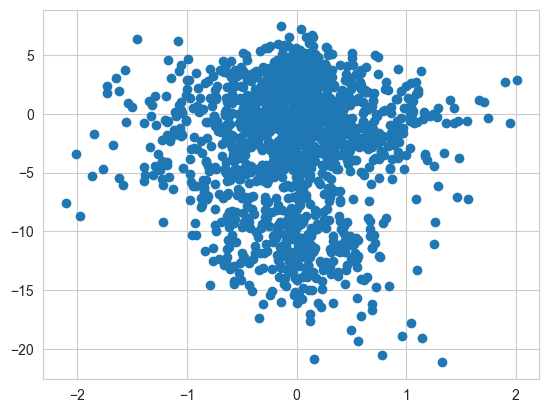

In [69]:
plt.scatter((Xtr @ isdrf.U.T)[:,3], Ytr)

In [27]:
def check_const(blocks_shape, th_const, th):
    const_blocks = np.zeros(len(blocks_shape), dtype=bool)
    const_idxs = []
    v_idxs = []
    for b, bs in enumerate(blocks_shape):
        if b == 0:
            block_idxs = list(range(bs))
        else:
            block_idxs = [j + sum(blocks_shape[:b]) for j in range(bs)]
        if th_const[b] < th:
            const_blocks[b] = True
            for idx in block_idxs:
                const_idxs.append(idx)
        else:
            for idx in block_idxs:
                v_idxs.append(idx)
    return const_blocks, const_idxs, v_idxs

In [6]:
isdrf.th_const

[np.float64(0.3312126975227928), np.float64(0.15670254553918903)]

In [32]:
check_const(isdrf.blocks_shape, isdrf.th_const, isdrf.th_const[1])

(array([False, False]), [], [0, 1, 2, 3])

In [ ]:
isdpreds = isdrf.predict_zeroshot(Xts)
isdfitted = isdrf.predict_zeroshot(Xtr)

In [55]:
from nldg.utils.jbd import ajbd

n_envs = len(np.unique(Etr))
p = Xtr.shape[1]
Sigma = np.zeros((n_envs, p, p))
for i, e in enumerate(np.unique(Etr)):
    n_e = np.sum(Etr == e)
    X_e = Xtr[(i * n_e) : ((i + 1) * n_e)]
    Sigma[i, :, :] = np.cov(X_e, rowvar=False)
U, blocks_shape, Sigma_diag, _, _ = ajbd(Sigma)

In [56]:
blocks_shape

[3, 1]

In [57]:
Sigma_diag[1,:,:]

array([[ 0.52385717,  0.48500252, -0.37745368, -0.04584472],
       [ 0.48500252,  1.43271849, -1.01396564, -0.15418475],
       [-0.37745368, -1.01396564,  1.24951887,  0.10577684],
       [-0.04584472, -0.15418475,  0.10577684,  0.37862584]])

In [66]:
OM = ortho_group.rvs(dim=p, random_state=np.random.default_rng(random_state))
np.cov(Xtr[Etr==0] @ OM.T, rowvar=False)

array([[ 1.43801627,  1.35217754,  0.95649083, -0.03921033],
       [ 1.35217754,  1.40682961,  0.64890345, -0.03299082],
       [ 0.95649083,  0.64890345,  1.16328152, -0.03226403],
       [-0.03921033, -0.03299082, -0.03226403,  0.22619758]])

In [ ]:
OM = ortho_group.rvs(dim=p, random_state=np.random.default_rng(random_state))
#Xrot = Xtr @ OM.T
Xrot = Xtr @ U.T
plt.scatter(Xrot[:, 3], Ytr)

In [ ]:
isdrf = IsdRF(n_estimators=50, min_samples_leaf=min_samples_leaf)
isdrf.find_invariant(Xtr, Ytr, Etr)

In [ ]:
isdrf.const_idxs

In [72]:
import numpy as np
from scipy.stats import ortho_group
from scipy.linalg import block_diag

p = 4
n_envs = 3
rng = np.random.default_rng(42)

# 1) Decide on the "true" basis for block diagonal
U = ortho_group.rvs(dim=p, random_state=rng)
block_sizes = [3, 1]  # same as your example

Sigma_list = []
rng_sigma = np.random.default_rng(42)
for e in range(n_envs):
    # For each environment, define block diag with dimension 3 and 1
    # e.g. random diagonal blocks:
    B1 = np.diag(rng.uniform(0.5, 2.0, size=3))
    B2 = np.diag(rng.uniform(0.5, 2.0, size=1))
    Block_e = block_diag(B1, B2)
    A = block_diag(*[rng_sigma.random((bs, bs)) for bs in block_sizes])
    print(A)

    # Now rotate it back to the original coordinate system
    Sigma_e = U.T @ Block_e @ U
    Sigma_list.append(Sigma_e)

[[0.77395605 0.43887844 0.85859792 0.        ]
 [0.69736803 0.09417735 0.97562235 0.        ]
 [0.7611397  0.78606431 0.12811363 0.        ]
 [0.         0.         0.         0.45038594]]
[[0.37079802 0.92676499 0.64386512 0.        ]
 [0.82276161 0.4434142  0.22723872 0.        ]
 [0.55458479 0.06381726 0.82763117 0.        ]
 [0.         0.         0.         0.6316644 ]]
[[0.75808774 0.35452597 0.97069802 0.        ]
 [0.89312112 0.7783835  0.19463871 0.        ]
 [0.466721   0.04380377 0.15428949 0.        ]
 [0.         0.         0.         0.68304895]]


In [68]:
Sigma_list

[array([[ 0.61426842, -0.05384575,  0.05167139, -0.08877444],
        [-0.05384575,  1.45290798, -0.04506158, -0.15327784],
        [ 0.05167139, -0.04506158,  1.51994112,  0.14331542],
        [-0.08877444, -0.15327784,  0.14331542,  1.52942891]]),
 array([[ 1.04715535, -0.0422295 ,  0.04536214, -0.07368054],
        [-0.0422295 ,  1.77028837,  0.01661557, -0.13419703],
        [ 0.04536214,  0.01661557,  1.8512839 ,  0.09269717],
        [-0.07368054, -0.13419703,  0.09269717,  1.79592167]]),
 array([[ 0.81256034, -0.09217652,  0.03372149, -0.09080876],
        [-0.09217652,  1.1814315 , -0.38322092,  0.28431325],
        [ 0.03372149, -0.38322092,  0.85959442,  0.01560336],
        [-0.09080876,  0.28431325,  0.01560336,  1.3717342 ]])]

## Adjust - Results Magging

In [2]:
mse_df_in = pd.read_csv('..\\..\\experiments\\new\\results_4\\mse_in.csv')
r2_df_in = pd.read_csv('..\\..\\experiments\\new\\results_4\\r2_in.csv')
mse_df_out = pd.read_csv('..\\..\\experiments\\new\\results_4\\mse_out.csv')
r2_df_out = pd.read_csv('..\\..\\experiments\\new\\results_4\\r2_out.csv')
max_mse_df = pd.read_csv('..\\..\\experiments\\new\\results_4\\maxmse.csv')

In [3]:
mse_in = np.zeros((50,))
r2_in = np.zeros((50,))
mse_out = np.zeros((50,))
r2_out = np.zeros((50,))
maxmse = np.zeros((50,))
for i in tqdm(range(50)):
    dtr, dts = gen_data_v3(n_train=1000, n_test=500, random_state=i)
    Xtr, Xts = (
            np.array(dtr.drop(columns=["E", "Y"])),
            np.array(dts.drop(columns=["E", "Y"])),
    )
    Ytr, Yts = np.array(dtr["Y"]), np.array(dts["Y"])
    Etr = np.array(dtr["E"])
    magging_rf_2 = MaggingRF(n_estimators=50, min_samples_leaf=10)
    magging_rf_2.fit(Xtr, Ytr)
    preds_magging_rf_2, _ = magging_rf_2.predict_maximin(Xtr, Xts)
    fitted_magging_rf_2, _ = magging_rf_2.predict_maximin(Xtr, Xtr)
    mse_in[i] = mean_squared_error(Ytr, fitted_magging_rf_2)
    r2_in[i] = r2_score(Ytr, fitted_magging_rf_2)
    mse_out[i] = mean_squared_error(Yts, preds_magging_rf_2)
    r2_out[i] = r2_score(Yts, preds_magging_rf_2)
    maxmse[i] = max_mse(Ytr, fitted_magging_rf_2, Etr)

100%|██████████| 50/50 [00:55<00:00,  1.11s/it]


In [4]:
mse_df_in['MaggingRF2'] = mse_in
r2_df_in['MaggingRF2'] = r2_in
mse_df_out['MaggingRF2'] = mse_out
r2_df_out['MaggingRF2'] = r2_out
max_mse_df['MaggingRF2'] = maxmse

In [5]:
from experiments.new.archive.utils import plot_mse_r2, plot_maxmse

results_dir = os.path.join(os.getcwd(), 'results_3')
isd=False
os.makedirs(results_dir, exist_ok=True)
plot_mse_r2(mse_df_in, r2_df_in, "sim_mse_r2_in.pdf", results_dir, out=False, isd=isd,)
plot_mse_r2(mse_df_out, r2_df_out, "sim_mse_r2_out.pdf", results_dir, isd=isd)
plot_maxmse(max_mse_df, "sim_maxmse.pdf", results_dir, isd=isd)

In [6]:
mse_df_in.to_csv(os.path.join(results_dir, "mse_in.csv"), index=False)
r2_df_in.to_csv(os.path.join(results_dir, "r2_in.csv"), index=False)
mse_df_out.to_csv(os.path.join(results_dir, "mse_out.csv"), index=False)
r2_df_out.to_csv(os.path.join(results_dir, "r2_out.csv"), index=False)
max_mse_df.to_csv(os.path.join(results_dir, "maxmse.csv"), index=False)

### Plot no magging

In [40]:
plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"],
        "text.latex.preamble": r"\usepackage{amsmath}\usepackage{amssymb}",
        "axes.labelsize": 22,
        "legend.fontsize": 18,
        "xtick.labelsize": 18,
        "ytick.labelsize": 16,
        "axes.unicode_minus": True,
    }
)
WIDTH = 12.0
HEIGHT = 6.0

def plot_mse_r2_nomag(
    mse_df: pd.DataFrame,
    r2_df: pd.DataFrame,
    name_plot: str,
    plots_folder: str,
    out: bool = True,
    isd: bool = False,
) -> None:
    """
    Plots the MSE and R2 comparison between different methods.

    Args:
         mse_df: DataFrame containing the MSE values for the methods.
         r2_df: DataFrame containing the R2 values for the methods.
         name_plot: Name of the plot to save in the dedicated folder.
         plots_folder: Folder where to save the plots.
         out: If true, the results refer to the test data.
         isd: If true, include the results of Invariant Subspace Decomposition.
    """
    c = ["tab:blue", "tab:orange", "tab:purple", "tab:red"]
    if isd:
        n_methods = mse_df.shape[1]
    else:
        n_methods = 4

    fig, ax = plt.subplots(1, 2, figsize=(WIDTH * 2, HEIGHT))
    if out:
        fig.suptitle(
            r"$\mathsf{MSE}$ and $R^2$ comparison - Test data",
            fontsize=22,
            fontweight="bold",
        )
    else:
        fig.suptitle(
            r"$\mathsf{MSE}$ and $R^2$ comparison - Train data",
            fontsize=22,
            fontweight="bold",
        )

    # Create violin plots
    vp_mse = ax[0].violinplot(
        [mse_df.iloc[:, i] for i in range(n_methods)],
        showmeans=True,
        showextrema=False,
        widths=0.4,
        positions=range(n_methods),
    )

    vp_r2 = ax[1].violinplot(
        [r2_df.iloc[:, i] for i in range(n_methods)],
        showmeans=True,
        showextrema=False,
        widths=0.4,
        positions=range(n_methods),
    )

    # Set colors for MSE violins
    for i, vp in enumerate(vp_mse["bodies"]):
        vp.set_facecolor(c[i])
        vp.set_edgecolor(c[i])
        vp.set_alpha(0.7)

    # Set colors for R² violins
    for i, vp in enumerate(vp_r2["bodies"]):
        vp.set_facecolor(c[i])
        vp.set_edgecolor(c[i])
        vp.set_alpha(0.7)

    # Set colors for mean lines
    vp_mse["cmeans"].set_color(c)
    vp_mse["cmeans"].set_linewidth(2.5)

    vp_r2["cmeans"].set_color(c)
    vp_r2["cmeans"].set_linewidth(2.5)

    # Labels and formatting
    ax[0].set_ylabel(r"$\mathsf{MSE}$")
    ax[1].set_ylabel(r"$R^2$")

    ax[0].set_xticks(range(n_methods))
    ax[1].set_xticks(range(n_methods))

    if isd:
        labels = [
            r"$\mathsf{RF}$",
            r"$\mathsf{MaximinRF}$",
            r"$\mathsf{MaggingRF2}$",
            r"$\mathsf{IsdRF}$",
        ]
    else:
        labels = [
            r"$\mathsf{RF}$",
            r"$\mathsf{MaximinRF}$",
            r"$\mathsf{MaggingRF}$",
            r"$\mathsf{MaggingRF2}$",
        ]
    ax[0].set_xticklabels(labels)
    ax[1].set_xticklabels(labels)

    ax[0].grid(
        True, which="both", axis="y", linestyle="--", linewidth=0.3, alpha=0.3
    )
    ax[1].grid(
        True, which="both", axis="y", linestyle="--", linewidth=0.3, alpha=0.3
    )

    plt.tight_layout()

    # Save plot
    plot_path = os.path.join(plots_folder, name_plot)
    plt.savefig(plot_path, bbox_inches="tight", dpi=300)
    plt.close()


def plot_maxmse_nomag(
    maxmse_df: pd.DataFrame,
    name_plot: str,
    plots_folder: str,
    isd: bool = False,
) -> None:
    """
    Plots the maximum MSE across environments to compare different methods.

    Args:
         maxmse_df: DataFrame containing the maximum MSE values
            for the methods.
         name_plot: Name of the plot to save in the dedicated folder.
         plots_folder: Folder where to save the plots.
         isd: If true, include the results of Invariant Subspace Decomposition.
    """
    c = ["tab:blue", "tab:orange", "tab:purple", "tab:red"]
    if isd:
        n_methods = 4
    else:
        n_methods = 4

    fig, ax = plt.subplots(figsize=(WIDTH, HEIGHT))
    fig.suptitle(
        r"Maximum $\mathsf{MSE}$ across environments",
        fontsize=22,
        fontweight="bold",
    )

    vp_maxmse = ax.violinplot(
        [maxmse_df.iloc[:, i] for i in range(n_methods)],
        showmeans=True,
        showextrema=False,
        widths=0.4,
        positions=range(n_methods),
    )

    # Set colors for the violins
    for i, vp in enumerate(vp_maxmse["bodies"]):
        vp.set_facecolor(c[i])
        vp.set_edgecolor(c[i])
        vp.set_alpha(0.7)

    # Customize the mean markers
    vp_maxmse["cmeans"].set_color(c)
    vp_maxmse["cmeans"].set_linewidth(2.5)

    # Labels and formatting
    ax.set_ylabel(r"$\mathsf{MSE}$")
    ax.set_xticks(range(n_methods))
    if isd:
        ax.set_xticklabels(
            [
                r"$\mathsf{RF}$",
                r"$\mathsf{MaximinRF}$",
                r"$\mathsf{MaggingRF2}$",
                r"$\mathsf{IsdRF}$",
            ]
        )
    else:
        ax.set_xticklabels(
            [
                r"$\mathsf{RF}$",
                r"$\mathsf{MaximinRF}$",
                r"$\mathsf{MaggingRF}$",
                r"$\mathsf{MaggingRF2}$",
            ]
        )

    ax.grid(
        True,
        which="both",
        axis="y",
        color="grey",
        linestyle="--",
        linewidth=0.3,
        alpha=0.3,
    )

    plt.tight_layout()

    plot_path = os.path.join(plots_folder, name_plot)
    plt.savefig(plot_path, bbox_inches="tight", dpi=300)
    plt.close()

In [41]:
mse_df_in = pd.read_csv('..\\..\\experiments\\new\\results_5\\mse_in.csv')
r2_df_in = pd.read_csv('..\\..\\experiments\\new\\results_5\\r2_in.csv')
mse_df_out = pd.read_csv('..\\..\\experiments\\new\\results_5\\mse_out.csv')
r2_df_out = pd.read_csv('..\\..\\experiments\\new\\results_5\\r2_out.csv')
max_mse_df = pd.read_csv('..\\..\\experiments\\new\\results_5\\maxmse.csv')

In [42]:
mse_df_in = mse_df_in.drop('MaggingRF', axis=1)
r2_df_in = r2_df_in.drop('MaggingRF', axis=1)
mse_df_out = mse_df_out.drop('MaggingRF', axis=1)
r2_df_out = r2_df_out.drop('MaggingRF', axis=1)
max_mse_df = max_mse_df.drop('MaggingRF', axis=1)

In [43]:
results_dir = os.path.join(os.getcwd(), 'results_5')
isd=True
os.makedirs(results_dir, exist_ok=True)

plot_mse_r2_nomag(mse_df_in, r2_df_in, "sim_mse_r2_in_nomag.pdf", results_dir, out=False, isd=isd,)
plot_mse_r2_nomag(mse_df_out, r2_df_out, "sim_mse_r2_out_nomag.pdf", results_dir, isd=isd)
plot_maxmse_nomag(max_mse_df, "sim_maxmse_nomag.pdf", results_dir, isd=isd)

## Parallel RF

In [2]:
dtr, dts = gen_data_v3(n_train=1000, n_test=500)
Xtr, Xts = np.array(dtr.drop(columns=['E', 'Y'])), np.array(dts.drop(columns=['E', 'Y']))
Ytr, Yts = np.array(dtr['Y']), np.array(dts['Y'])
Etr = np.array(dtr['E'])
min_samples_leaf = 10

In [3]:
mrf = RF4DG(criterion='maximin', n_estimators=50, min_samples_leaf=min_samples_leaf)
mrf.fit(Xtr, Ytr, Etr)
mpreds = mrf.predict(Xts)
mfitted = mrf.predict(Xtr)

100%|██████████| 50/50 [01:32<00:00,  1.86s/it]


In [4]:
mean_squared_error(Ytr, mfitted), r2_score(Ytr, mfitted)

(3.3146568897298128, 0.7661949363985621)

In [5]:
mean_squared_error(Yts, mpreds), r2_score(Yts, mpreds)

(1.5027114915191073, 0.8752394226574021)

In [6]:
max_mse(Ytr, mfitted, Etr)

np.float64(4.306904342015246)

In [7]:
mrf2 = RF4DG(criterion='maximin', n_estimators=50, min_samples_leaf=min_samples_leaf, parallel=True)
mrf2.fit(Xtr, Ytr, Etr)
mpreds2 = mrf2.predict(Xts)
mfitted2 = mrf2.predict(Xtr)

100%|██████████| 50/50 [00:08<00:00,  5.89it/s]


In [8]:
mean_squared_error(Ytr, mfitted2), r2_score(Ytr, mfitted2)

(3.3146568897298128, 0.7661949363985621)

In [9]:
mean_squared_error(Yts, mpreds2), r2_score(Yts, mpreds2)

(1.5027114915191073, 0.8752394226574021)

In [10]:
max_mse(Ytr, mfitted2, Etr)

np.float64(4.306904342015246)